In [230]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.__version__

'2.3.0'

In [231]:
buffer_size = 60000
batch_size = 128
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()
training_images = x_train.reshape(x_train.shape[0],28,28,1).astype("float32")
training_images = training_images/255.0
train_dataset = tf.data.Dataset.from_tensor_slices(training_images).shuffle(buffer_size).batch(batch_size , drop_remainder = True)

In [232]:
def get_noise(batch_size , z_dim):
    return tf.random.normal([batch_size,z_dim])

In [233]:
def generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256 , input_shape = (64,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Reshape((7,7,256)))
    
    model.add(tf.keras.layers.UpSampling2D()) #14x14
    model.add(tf.keras.layers.Conv2D(128 , (5,5) , strides = (1,1), padding = "same")) #14x14
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.UpSampling2D()) #28x28
    model.add(tf.keras.layers.Conv2D(64 , (5,5) , strides = (2,2), padding = "same")) #14x14
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.UpSampling2D()) #28x28
    model.add(tf.keras.layers.Conv2D(1 , (5,5) , strides = (1,1), padding = "same" , activation = "tanh"))
    
    return model
    
    
    

In [234]:
def critic():
    model = tf.keras.Sequential()
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64,(5,5), strides = (2,2) , padding = "same"  ,input_shape = (28,28,1)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    
    model.add(tf.keras.layers.Conv2D(128,(5,5), strides = (2,2) , padding = "same"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
    
    
    return model

    

In [235]:
gen = generator()
crit = critic()

In [236]:
noise = get_noise(128,64)
out = gen(noise)
out.shape

TensorShape([128, 28, 28, 1])

In [237]:
#testing critic
rand = tf.random.normal([1,28,28,1])
out = crit(rand)
out

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.0882687]], dtype=float32)>

In [238]:
@tf.function
def get_gradient(crit,real,fake,epsilon):
    
    mixed = real * epsilon + (1 - epsilon)* fake
    with tf.GradientTape() as gtape:
        gtape.watch(mixed)
        mixed_score = crit(mixed , training = True)
        
    grad = gtape.gradient(mixed_score , mixed)
    return grad

In [239]:
def gradient_penalty(gradient):
    
    grad_norm = tf.norm(gradient)
    penalty = tf.reduce_mean((grad_norm - 1)**2)
    
    return penalty
    

In [240]:
def gen_loss(fake_output):
    
    
    loss = -1 * tf.reduce_mean(fake_output)
    return loss

In [241]:

def critic_loss(fake_output , real_output , gp , c_lambda):
    
    
    loss = -(tf.reduce_mean(real_output) - tf.reduce_mean
             (fake_output)) + (c_lambda * gp)
    return loss

In [242]:
#testing gradient
real = tf.random.normal([1,28,28,1])
fake = tf.random.normal([1,28,28,1])
grad = get_gradient(crit ,real = real , fake = fake , epsilon = 0.1)
grad.shape

TensorShape([1, 28, 28, 1])

In [243]:
#testing gradient_panalty
penalty = gradient_penalty(grad)
penalty

<tf.Tensor: shape=(), dtype=float32, numpy=0.06894139>

In [244]:
#testinf critic's loss
fake_output = crit(fake)
real_output = crit(real)

loss = critic_loss(fake_output, real_output , penalty , 0.5)
loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.14870897>

In [245]:
gen_optimizer = tf.keras.optimizers.Adam(0.002,0.5,0.99)
critic_optimizer = tf.keras.optimizers.Adam(0.002,0.5,0.99)

In [246]:
z_dim = 64
epochs = 50
c_lambda = 10
# epsilon = 0.5

In [247]:
@tf.function
def train_step(real_images):
    
    
    
    with tf.GradientTape() as gen_tape , tf.GradientTape() as crit_tape:
        
        noises = get_noise(batch_size , z_dim)
        fake_images = gen(noises,training = True)
        fake_outputs = crit(fake_images , training = True)
        real_outputs = crit(real_images , training = True)
        epsilon = tf.random.uniform([batch_size,28,28,1])
        grad = get_gradient(crit,real = real_images,fake = fake_images,epsilon = epsilon)
        penalty = gradient_penalty(grad)
        ######################################################################
        g_loss = gen_loss(fake_outputs )
        c_loss = critic_loss(fake_outputs, real_outputs , penalty , c_lambda )
        
    gen_grad = gen_tape.gradient(g_loss , gen.trainable_variables)
    critic_grad = crit_tape.gradient(c_loss, crit.trainable_variables)
    
    gen_optimizer.apply_gradients(zip(gen_grad ,gen.trainable_variables ))
    critic_optimizer.apply_gradients(zip(critic_grad , crit.trainable_variables))
    
    return g_loss , c_loss
    
    
    


In [248]:
def train(dataset , epochs):
    
    
    mean_gen_loss_list = []
    mean_critic_loss_list = []

    for epoch in range(epochs):
        gen_loss_list = []
        critic_loss_list = []
        for image in dataset:
            
            g_loss, c_loss , = train_step(image)
            
            gen_loss_list.append(g_loss)
            critic_loss_list.append(c_loss)
            
        mean_g_loss = sum(gen_loss_list)/len(gen_loss_list)
        mean_c_loss = sum(critic_loss_list)/len(critic_loss_list)
        mean_gen_loss_list.append(mean_g_loss)
        mean_critic_loss_list.append(mean_c_loss)    
            
        print (f'Epoch {epoch+1}, gen loss={mean_g_loss},critic loss={mean_c_loss}')
        
    return mean_gen_loss_list , mean_critic_loss_list
            
    

In [249]:
G_loss , C_loss = train(train_dataset,epochs)

Epoch 1, gen loss=-0.04804778844118118,critic loss=90.42991638183594
Epoch 2, gen loss=0.2453356683254242,critic loss=36.77377700805664
Epoch 3, gen loss=1.0265861749649048,critic loss=43.070552825927734
Epoch 4, gen loss=1.9087574481964111,critic loss=22.097698211669922
Epoch 5, gen loss=2.7723965644836426,critic loss=3.8943285942077637
Epoch 6, gen loss=3.274552345275879,critic loss=6.4229230880737305
Epoch 7, gen loss=3.2000222206115723,critic loss=4.617011070251465
Epoch 8, gen loss=2.770059108734131,critic loss=1.6506288051605225
Epoch 9, gen loss=4.053884506225586,critic loss=0.719880223274231
Epoch 10, gen loss=1.8372833728790283,critic loss=0.11393318325281143
Epoch 11, gen loss=1.842502474784851,critic loss=0.17819102108478546
Epoch 12, gen loss=-0.27201923727989197,critic loss=0.09824234247207642
Epoch 13, gen loss=-0.4535883665084839,critic loss=0.05050205439329147
Epoch 14, gen loss=-0.5631150603294373,critic loss=0.0027873730286955833
Epoch 15, gen loss=0.05796781182289123

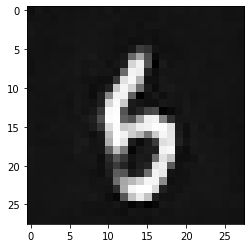

In [273]:
i = (gen(np.random.rand(1,64)).numpy().reshape(28,28) )
plt.imshow(i*255,cmap="gray")

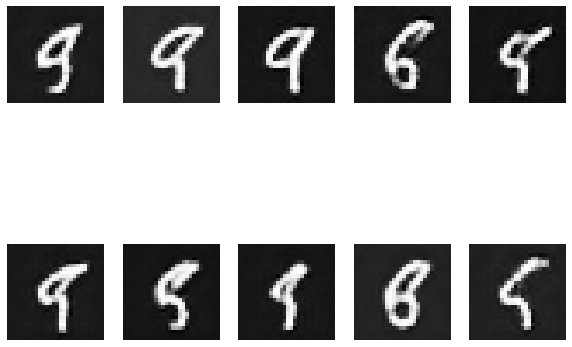

In [278]:
#mode collapse is not observed


noises = np.random.rand(10,64)
images = []
for i in range(noises.shape[0]):
    images.append((gen(noises[i].reshape(1,64)).numpy().reshape(28,28))*(255))

fig , ax = plt.subplots(2,5 , figsize = (10,8))

for j in range(2):
  for i in range(5):
    plt.sca(ax[j][i])
    if j == 0:
      plt.imshow(images[i] , cmap = "gray")
    else:
      plt.imshow(images[i+5],cmap = "gray")
    plt.axis("off")
    

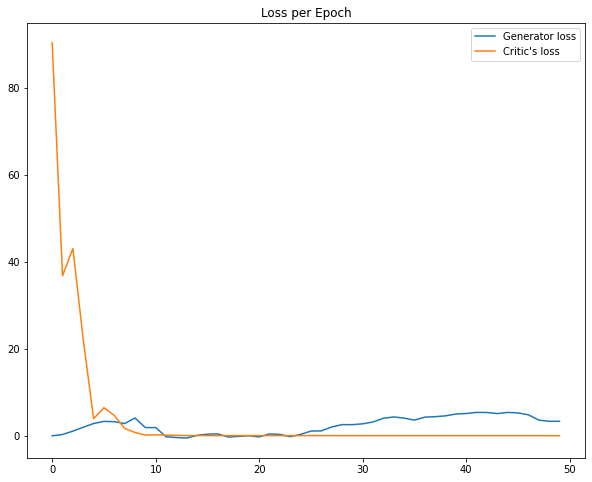

In [253]:
plt.figure(figsize=(10,8))
plt.plot(G_loss , label = "Generator loss" , linewidth = 1.5)
plt.plot(C_loss, label = "Critic's loss" , linewidth = 1.5)
plt.legend()
plt.title("Loss per Epoch")
plt.show()
